# Evasion Attack: Fast Minimum-Norm (FMN)

This notebook demonstrates how to perform the Fast Minimum-Norm (FMN) evasion attack against our deployed MNIST digit classifier. FMN is one of the four evasion attack algorithms mentioned in the Security and Privacy of AI Knowledge Guide.

## Overview of FMN Attack

The Fast Minimum-Norm (FMN) attack, introduced by Pintor et al. in 2021, is a more recent and efficient approach to creating adversarial examples. Unlike PGD which focuses on finding any adversarial example within an epsilon ball, FMN directly targets finding the adversarial example with the smallest possible perturbation norm.

The key innovation of FMN is its adaptive step size approach. Rather than using a fixed step size like PGD, FMN uses binary search to find the minimal step size needed to cross the decision boundary. This allows it to efficiently find adversarial examples with minimal perturbation.

The mathematical formulation can be described as:

1. Start with the original input x
2. Compute the gradient direction g = ∇ℓ(x, y)
3. Use binary search to find the smallest step size α such that x + α·g is misclassified
4. Repeat from step 2, but now computing the gradient at the current adversarial example

## Steps in this notebook:
1. Import required libraries
2. Set up connection to the deployed model
3. Load test data
4. Implement the FMN attack
5. Generate adversarial examples
6. Evaluate attack success rate
7. Visualize results
8. Compare with other attacks (FGSM, PGD, and C&W)

## 1. Import Required Libraries

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import requests
import json
import time
from tqdm.notebook import tqdm
from PIL import Image
import io
import base64

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Set up connection to the deployed model

We'll create functions to interact with the deployed model API.

In [12]:
# API endpoint of the deployed model
API_URL = "http://localhost:5000"

def get_model_info():
    """Get information about the deployed model"""
    response = requests.get(f"{API_URL}/info")
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Error fetching model info: {response.text}")

def get_prediction(pixels):
    """Get prediction for an image from the deployed model"""
    # Ensure pixels are flattened
    pixels_flat = pixels.reshape(-1).tolist()
    
    # Prepare the request data
    data = {
        'pixels': pixels_flat
    }
    
    # Send the request
    response = requests.post(f"{API_URL}/predict_raw", json=data)
    
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Error getting prediction: {response.text}")

def get_gradient(pixels, label):
    """Get the gradient of the loss with respect to the input from the deployed model"""
    # Ensure pixels are flattened
    pixels_flat = pixels.reshape(-1).tolist()
    
    # Prepare the request data
    data = {
        'pixels': pixels_flat,
        'label': int(label)
    }
    
    # Send the request
    response = requests.post(f"{API_URL}/get_gradient", json=data)
    
    if response.status_code == 200:
        result = response.json()
        gradient = np.array(result['gradient'])
        gradient_shape = result['gradient_shape']
        return gradient.reshape(gradient_shape)
    else:
        raise Exception(f"Error getting gradient: {response.text}")
        
# Test the API connection
try:
    model_info = get_model_info()
    print("Successfully connected to the model API!")
    print(f"Model: {model_info['model_name']}")
    print(f"Input shape: {model_info['input_shape']}")
    print(f"Classes: {model_info['classes']}")
    print(f"Test accuracy: {model_info['test_accuracy']}")
except Exception as e:
    print(f"Failed to connect to the model API: {e}")
    print("Make sure the Flask server is running at http://localhost:5000")

Successfully connected to the model API!
Model: MNIST Digit Classifier
Input shape: [28, 28, 1]
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Test accuracy: 0.9905999898910522


## 3. Load Test Data

We'll load the MNIST test dataset to use for our attack.

In [13]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(_, _), (x_test, y_test) = mnist.load_data()

# Preprocess the data (normalize to 0-1)
x_test = x_test.astype('float32') / 255.0

# Reshape to include channel dimension (MNIST is grayscale, so 1 channel)
x_test = x_test.reshape(-1, 28, 28, 1)

print(f"Loaded {len(x_test)} test images")
print(f"Data shape: {x_test.shape}")
print(f"Labels shape: {y_test.shape}")

Loading MNIST dataset...
Loaded 10000 test images
Data shape: (10000, 28, 28, 1)
Labels shape: (10000,)


### Examine Some Images

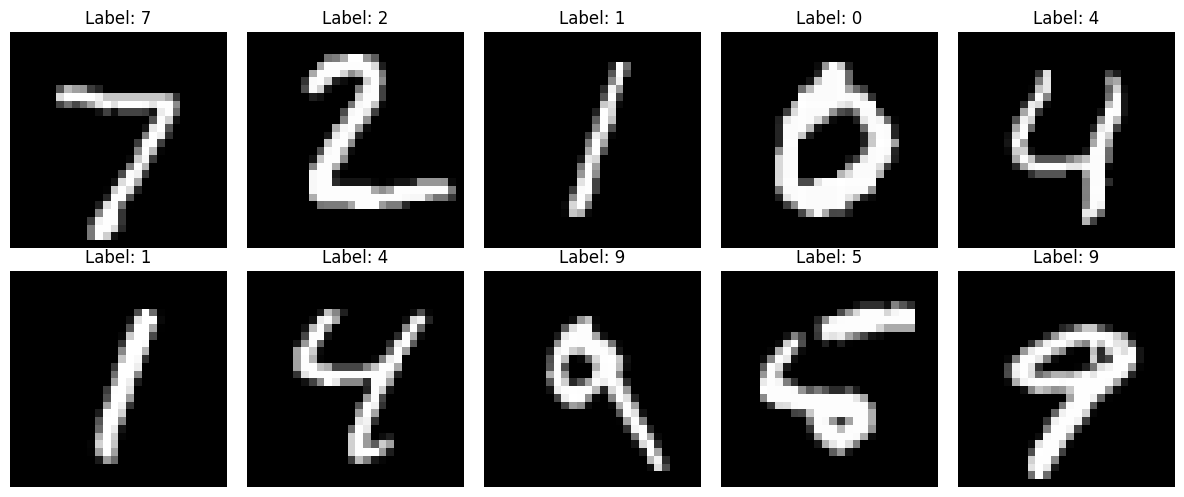

In [14]:
# Display some test images
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Verify Model Predictions

Before attempting any attack, let's verify that the deployed model is correctly classifying the original images.

In [15]:
# Test model predictions on a few original images
num_test_samples = 5
test_indices = np.random.choice(len(x_test), num_test_samples, replace=False)

print("Testing model predictions on original images...")
for i, idx in enumerate(test_indices):
    # Get the image and true label
    image = x_test[idx]
    true_label = y_test[idx]
    
    # Get model prediction
    result = get_prediction(image)
    predicted_class = result['predicted_class']
    confidence = result['confidence']
    
    print(f"Sample {i+1}: True label = {true_label}, Predicted class = {predicted_class}, Confidence = {confidence:.4f}")

Testing model predictions on original images...
Sample 1: True label = 6, Predicted class = 6, Confidence = 1.0000
Sample 2: True label = 2, Predicted class = 2, Confidence = 1.0000
Sample 3: True label = 3, Predicted class = 3, Confidence = 1.0000
Sample 4: True label = 7, Predicted class = 7, Confidence = 0.9988
Sample 5: True label = 2, Predicted class = 2, Confidence = 1.0000


## 4. Implement the FMN Attack

The Fast Minimum-Norm (FMN) attack focuses on finding the adversarial example with the smallest possible perturbation. The key steps are:

1. Start with the original input
2. Compute the gradient direction
3. Use binary search to find the minimal step size that crosses the decision boundary
4. Improve the adversarial example by iteratively repeating steps 2-3 from the current best position

Here's our implementation of the FMN attack:

In [16]:
def is_adversarial(image, true_label):
    """
    Check if an image is adversarial (misclassified by the model)
    
    Args:
        image: The image to check
        true_label: The true label of the original image
        
    Returns:
        Boolean indicating if the image is adversarial
    """
    result = get_prediction(image)
    predicted_class = int(result['predicted_class'])
    return predicted_class != true_label

def binary_search_step(original_image, direction, true_label, alpha_min=0, alpha_max=1, tol=1e-5, max_iterations=10):
    """
    Binary search to find the minimal step size needed to cross the decision boundary
    
    Args:
        original_image: The starting image
        direction: The gradient direction to move in
        true_label: The true label of the original image
        alpha_min: Minimum step size
        alpha_max: Maximum step size
        tol: Tolerance for binary search
        max_iterations: Maximum number of binary search iterations
        
    Returns:
        The minimal step size and the resulting adversarial image
    """
    # Normalize the direction to have unit L2 norm
    direction_norm = np.linalg.norm(direction)
    if direction_norm > 0:
        normalized_direction = direction / direction_norm
    else:
        # If gradient is zero, return original image
        return 0, original_image
    
    # Check if alpha_max is sufficient to create an adversarial example
    adv_image_max = original_image + alpha_max * normalized_direction
    adv_image_max = np.clip(adv_image_max, 0, 1)
    
    if not is_adversarial(adv_image_max, true_label):
        # If alpha_max doesn't cross boundary, return with failure indicator
        return -1, original_image
    
    # Binary search to find the minimal step size
    alpha_mid = alpha_min
    for _ in range(max_iterations):
        alpha_mid = (alpha_min + alpha_max) / 2
        adv_image_mid = original_image + alpha_mid * normalized_direction
        adv_image_mid = np.clip(adv_image_mid, 0, 1)
        
        if is_adversarial(adv_image_mid, true_label):
            alpha_max = alpha_mid
        else:
            alpha_min = alpha_mid
            
        if (alpha_max - alpha_min) < tol:
            break
    
    # Return the adversarial image at the boundary
    final_image = original_image + alpha_max * normalized_direction
    final_image = np.clip(final_image, 0, 1)
    
    return alpha_max, final_image

def fmn_attack(image, label, max_iterations=10, initial_alpha_max=1.0, norm_constraint=None):
    """
    Generate an adversarial example using the Fast Minimum-Norm (FMN) attack
    
    Args:
        image: Original input image
        label: True label of the image
        max_iterations: Maximum number of iterations
        initial_alpha_max: Initial maximum step size
        norm_constraint: Optional constraint on the L2 norm of the perturbation
        
    Returns:
        Adversarial example
    """
    # Start with the original image
    current_image = np.copy(image)
    best_adv_image = None
    best_norm = float('inf')
    
    print("Starting FMN attack...")
    
    for i in range(max_iterations):
        # Get the gradient of the loss with respect to the input
        gradient = get_gradient(current_image, label)
        
        # Use binary search to find minimal step size
        alpha, adv_image = binary_search_step(
            current_image, 
            gradient, 
            label, 
            alpha_max=initial_alpha_max
        )
        
        # If binary search failed, try a different approach or stop
        if alpha < 0:
            print(f"Iteration {i+1}: Binary search failed to find adversarial example.")
            # If we have a previous successful adversarial example, return it
            if best_adv_image is not None:
                return best_adv_image
            
            # Otherwise, try a simple step in the gradient direction
            adv_image = current_image + initial_alpha_max * np.sign(gradient)
            adv_image = np.clip(adv_image, 0, 1)
            
            # Check if this is adversarial
            if is_adversarial(adv_image, label):
                print(f"Iteration {i+1}: Recovered using sign step.")
                current_image = adv_image
            else:
                print(f"Iteration {i+1}: Failed to find adversarial example. Stopping.")
                # If we have a previous successful adversarial example, return it
                if best_adv_image is not None:
                    return best_adv_image
                # Otherwise, return the current image (attack failed)
                return current_image
        else:
            # Update the current image to the adversarial example
            current_image = adv_image
            
            # Calculate the perturbation norm
            perturbation = current_image - image
            perturbation_norm = np.linalg.norm(perturbation)
            
            print(f"Iteration {i+1}: Found adversarial example with L2 norm = {perturbation_norm:.4f}")
            
            # Update the best adversarial example if this one has a smaller norm
            if perturbation_norm < best_norm:
                best_adv_image = current_image
                best_norm = perturbation_norm
            
            # If there's a norm constraint and we're under it, we can stop early
            if norm_constraint is not None and best_norm <= norm_constraint:
                print(f"Stopping early: L2 norm {best_norm:.4f} is below constraint {norm_constraint:.4f}")
                break
    
    # Return the best adversarial example found
    return best_adv_image if best_adv_image is not None else current_image

## 5. Generate Adversarial Examples

Now let's genermate adversarial examples for a subset of the test data using the FMN attack.

In [18]:
# Define the number of samples to attack and the attack parameters
num_samples = 10  # Number of samples to attack
max_iterations = 10  # Maximum number of FMN iterations
initial_alpha_max = 1.0  # Initial maximum step size

# Randomly select samples from the test set
sample_indices = np.random.choice(len(x_test), num_samples, replace=False)

# Lists to store results
original_images = []
adversarial_images = []
original_preds = []
adversarial_preds = []
true_labels = []
perturbations = []

print(f"Generating adversarial examples using FMN attack with:")
print(f"  - max_iterations: {max_iterations}")
print(f"  - initial_alpha_max: {initial_alpha_max}")

# Generate adversarial examples
for i, idx in enumerate(tqdm(sample_indices)):
    # Get the original image and label
    original_image = x_test[idx]
    true_label = y_test[idx]
    
    # Get original prediction
    try:
        orig_result = get_prediction(original_image)
        original_pred = orig_result['predicted_class']
        
        # Only attack correctly classified images
        if int(original_pred) == true_label:
            print(f"\nAttacking sample {i+1}/{len(sample_indices)}, Image index: {idx}, True label: {true_label}")
            
            # Generate adversarial example
            adversarial_image = fmn_attack(
                original_image, 
                true_label, 
                max_iterations=max_iterations,
                initial_alpha_max=initial_alpha_max
            )
            
            # Ensure adversarial_image has the correct shape (should match original_image)
            if adversarial_image.shape != original_image.shape:
                print(f"Warning: Reshaping adversarial image from {adversarial_image.shape} to {original_image.shape}")
                adversarial_image = adversarial_image.reshape(original_image.shape)
            
            # Calculate perturbation
            perturbation = adversarial_image - original_image
            
            # Get adversarial prediction
            adv_result = get_prediction(adversarial_image)
            adversarial_pred = adv_result['predicted_class']
            
            print(f"Original prediction: {original_pred}, Adversarial prediction: {adversarial_pred}")
            
            # Store results
            original_images.append(original_image)
            adversarial_images.append(adversarial_image)
            original_preds.append(original_pred)
            adversarial_preds.append(adversarial_pred)
            true_labels.append(true_label)
            perturbations.append(perturbation)
    except Exception as e:
        print(f"Error processing sample {idx}: {e}")
        continue

# Debug: Check shapes before converting to numpy arrays
print("\nChecking shapes of all adversarial images:")
for i, adv_img in enumerate(adversarial_images):
    print(f"Image {i} shape: {adv_img.shape}")

# Convert lists to numpy arrays for easier handling
original_images = np.array(original_images)
adversarial_images = np.array(adversarial_images)
original_preds = np.array(original_preds)
adversarial_preds = np.array(adversarial_preds)
true_labels = np.array(true_labels)
perturbations = np.array(perturbations)

print(f"Generated {len(adversarial_images)} adversarial examples")
print(f"Original images shape: {original_images.shape}")
print(f"Adversarial images shape: {adversarial_images.shape}")

Generating adversarial examples using FMN attack with:
  - max_iterations: 10
  - initial_alpha_max: 1.0


  0%|          | 0/10 [00:00<?, ?it/s]


Attacking sample 1/10, Image index: 8740, True label: 1
Starting FMN attack...
Iteration 1: Binary search failed to find adversarial example.
Iteration 1: Recovered using sign step.
Iteration 2: Found adversarial example with L2 norm = 17.9614
Iteration 3: Found adversarial example with L2 norm = 17.9611
Iteration 4: Found adversarial example with L2 norm = 17.9609
Iteration 5: Found adversarial example with L2 norm = 17.9606
Iteration 6: Found adversarial example with L2 norm = 17.9604
Iteration 7: Found adversarial example with L2 norm = 17.9602
Iteration 8: Found adversarial example with L2 norm = 17.9599
Iteration 9: Found adversarial example with L2 norm = 17.9597
Iteration 10: Found adversarial example with L2 norm = 17.9594
Original prediction: 1, Adversarial prediction: 8

Attacking sample 2/10, Image index: 7755, True label: 8
Starting FMN attack...
Iteration 1: Binary search failed to find adversarial example.
Iteration 1: Recovered using sign step.
Iteration 2: Found advers

## 6. Evaluate Attack Success Rate

Let's evaluate how successful our FMN attack was by calculating the attack success rate.

In [19]:
# Calculate attack success rate
successful_attacks = (adversarial_preds != true_labels)
attack_success_rate = np.mean(successful_attacks) * 100

print(f"Attack Success Rate: {attack_success_rate:.2f}%")
print(f"Number of successful attacks: {np.sum(successful_attacks)} out of {len(adversarial_images)}")

# Calculate average perturbation magnitude
avg_perturbation_l2 = np.mean([np.linalg.norm(p) for p in perturbations])
avg_perturbation_linf = np.mean([np.max(np.abs(p)) for p in perturbations])

print(f"Average L2 perturbation magnitude: {avg_perturbation_l2:.4f}")
print(f"Average L∞ perturbation magnitude: {avg_perturbation_linf:.4f}")

Attack Success Rate: 100.00%
Number of successful attacks: 10 out of 10
Average L2 perturbation magnitude: 12.6905
Average L∞ perturbation magnitude: 0.7396


## 7. Visualize Results

Now, let's visualize the original images, perturbations, and adversarial examples to better understand the attack.

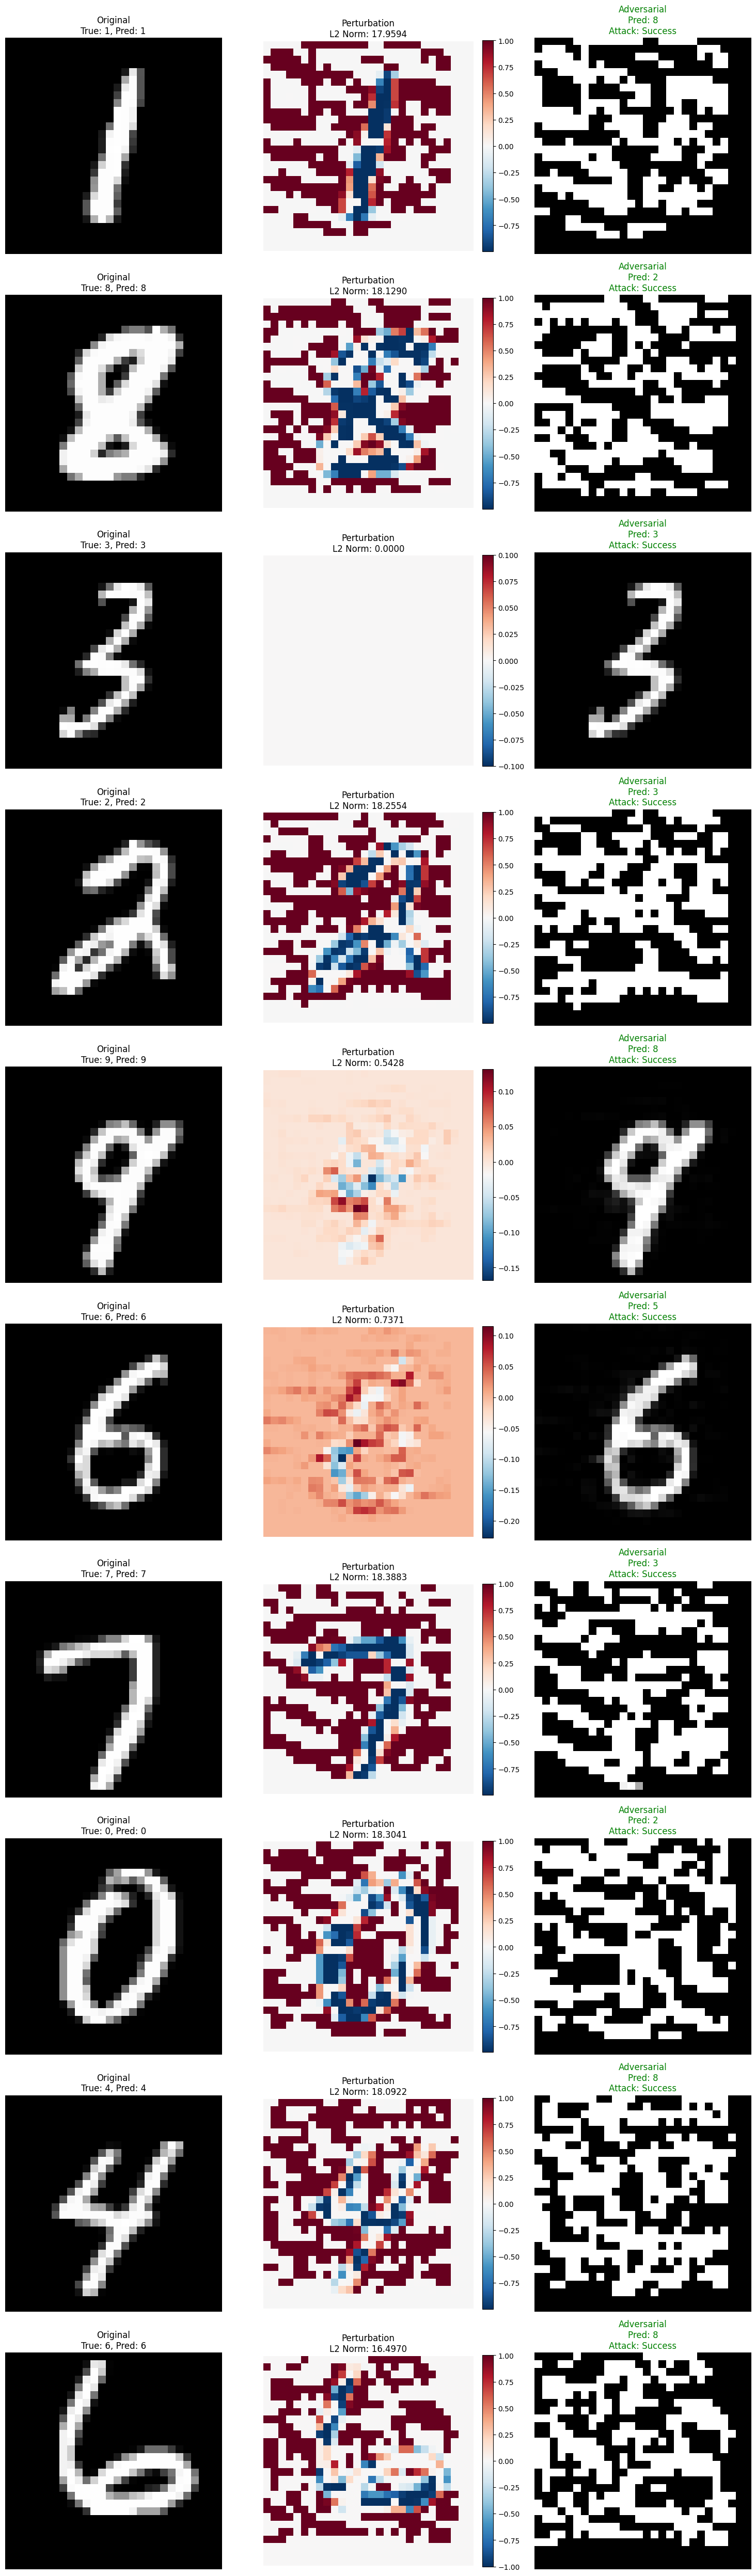

In [20]:
# Display all the results
num_to_display = min(10, len(adversarial_images))

plt.figure(figsize=(15, 5 * num_to_display))

for i in range(num_to_display):
    # Original image
    plt.subplot(num_to_display, 3, 3*i + 1)
    plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Original\nTrue: {true_labels[i]}, Pred: {original_preds[i]}")
    plt.axis('off')
    
    # Perturbation
    plt.subplot(num_to_display, 3, 3*i + 2)
    plt.imshow(perturbations[i].reshape(28, 28), cmap='RdBu_r')
    plt.title(f"Perturbation\nL2 Norm: {np.linalg.norm(perturbations[i]):.4f}")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    # Adversarial image
    plt.subplot(num_to_display, 3, 3*i + 3)
    plt.imshow(adversarial_images[i].reshape(28, 28), cmap='gray')
    color = 'green' if successful_attacks[i] else 'red'
    result = 'Success' if successful_attacks[i] else 'Failure'
    plt.title(f"Adversarial\nPred: {adversarial_preds[i]}\nAttack: {result}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 8. Implement Other Attacks for Comparison

Let's implement simplified versions of FGSM, PGD, and a basic version of C&W to compare with FMN.

In [22]:
def fgsm_attack(image, label, epsilon=0.1):
    """
    Generates an adversarial example using the Fast Gradient Sign Method
    
    Args:
        image: Input image to be perturbed (numpy array)
        label: True label of the image
        epsilon: Perturbation magnitude
        
    Returns:
        Adversarial example
    """
    # Get the gradient of the loss with respect to the input
    gradient = get_gradient(image, label)
    
    # Take the sign of the gradient
    sign_gradient = np.sign(gradient)
    
    # Perturb the input in the direction of the sign of the gradient
    perturbed_image = image + epsilon * sign_gradient
    
    # Clip the perturbed image to ensure it's within the valid range (0-1)
    perturbed_image = np.clip(perturbed_image, 0, 1)
    
    return perturbed_image

def pgd_attack(image, label, epsilon=0.1, alpha=0.01, num_iterations=20, random_start=True):
    """
    Generates an adversarial example using the Projected Gradient Descent method
    
    Args:
        image: Input image to be perturbed (numpy array)
        label: True label of the image
        epsilon: Maximum perturbation magnitude (L∞ norm)
        alpha: Step size for each iteration
        num_iterations: Number of iterations to run the attack
        random_start: Whether to start with a random perturbation within the epsilon-ball
        
    Returns:
        Adversarial example
    """
    # Initialize the adversarial example (optionally with random noise)
    if random_start:
        # Start with random noise within epsilon-ball
        noise = np.random.uniform(-epsilon, epsilon, image.shape)
        adv_image = image + noise
        adv_image = np.clip(adv_image, 0, 1)  # Ensure valid image range
    else:
        # Start with the original image
        adv_image = np.copy(image)
    
    # Iteratively refine the adversarial example
    for i in range(num_iterations):
        # Calculate gradient
        gradient = get_gradient(adv_image, label)
        
        # Take a step in the direction of the sign of the gradient
        signed_gradient = np.sign(gradient)
        adv_image = adv_image + alpha * signed_gradient
        
        # Project the perturbation back onto the epsilon-ball
        perturbation = adv_image - image
        perturbation = np.clip(perturbation, -epsilon, epsilon)
        adv_image = image + perturbation
        
        # Clip to valid image range
        adv_image = np.clip(adv_image, 0, 1)
    
    return adv_image

def simplified_cw_attack(image, label, max_iterations=50, learning_rate=0.01):
    """
    Simplified version of the C&W attack
    
    Args:
        image: Input image to be perturbed (numpy array)
        label: True label of the image
        max_iterations: Maximum number of iterations
        learning_rate: Learning rate for gradient descent
        
    Returns:
        Adversarial example
    """
    # Start with the original image
    adv_image = np.copy(image)
    
    for i in range(max_iterations):
        # Get gradient
        gradient = get_gradient(adv_image, label)
        
        # Normalize gradient
        gradient_norm = np.linalg.norm(gradient) + 1e-8  # Avoid division by zero
        normalized_gradient = gradient / gradient_norm
        
        # Update adversarial image with normalized gradient
        adv_image = adv_image + learning_rate * normalized_gradient
        
        # Clip to valid image range
        adv_image = np.clip(adv_image, 0, 1)
        
        # Check if the attack was successful
        if is_adversarial(adv_image, label):
            # If successful, try to reduce the perturbation
            alpha = 0.5
            while alpha > 0.01:
                # Try to move back towards the original image
                temp_image = alpha * image + (1 - alpha) * adv_image
                
                # Check if still adversarial
                if is_adversarial(temp_image, label):
                    adv_image = temp_image
                
                # Reduce step size
                alpha *= 0.5
            break
    
    return adv_image

## 9. Compare All Attack Methods

Let's compare FMN with FGSM, PGD, and our simplified C&W on a small subset of images.

In [23]:
# Set comparison parameters
comparison_samples = min(5, len(original_images))  # Use a smaller subset for comparison
fgsm_epsilon = 0.1
pgd_epsilon = 0.1
pgd_alpha = 0.01
pgd_iterations = 20

# Lists to store results
fgsm_adv_images = []
pgd_adv_images = []
cw_adv_images = []
fgsm_preds = []
pgd_preds = []
cw_preds = []
fgsm_success = []
pgd_success = []
cw_success = []

print("Comparing all attack methods on the same images...")
for i in range(comparison_samples):
    print(f"Processing image {i+1}/{comparison_samples}...")
    image = original_images[i]
    true_label = true_labels[i]
    
    # Generate adversarial examples with different methods
    fgsm_adv = fgsm_attack(image, true_label, epsilon=fgsm_epsilon)
    pgd_adv = pgd_attack(image, true_label, epsilon=pgd_epsilon, alpha=pgd_alpha, num_iterations=pgd_iterations)
    cw_adv = simplified_cw_attack(image, true_label, max_iterations=20, learning_rate=0.01)
    
    # Get predictions
    fgsm_result = get_prediction(fgsm_adv)
    pgd_result = get_prediction(pgd_adv)
    cw_result = get_prediction(cw_adv)
    
    # Store results
    fgsm_adv_images.append(fgsm_adv)
    pgd_adv_images.append(pgd_adv)
    cw_adv_images.append(cw_adv)
    fgsm_preds.append(fgsm_result['predicted_class'])
    pgd_preds.append(pgd_result['predicted_class'])
    cw_preds.append(cw_result['predicted_class'])
    fgsm_success.append(fgsm_result['predicted_class'] != str(true_label))
    pgd_success.append(pgd_result['predicted_class'] != str(true_label))
    cw_success.append(cw_result['predicted_class'] != str(true_label))

# Convert to numpy arrays
fgsm_adv_images = np.array(fgsm_adv_images)
pgd_adv_images = np.array(pgd_adv_images)
cw_adv_images = np.array(cw_adv_images)

# Calculate success rates
fgsm_success_rate = np.mean(fgsm_success) * 100
pgd_success_rate = np.mean(pgd_success) * 100
cw_success_rate = np.mean(cw_success) * 100
fmn_success_rate = np.mean(successful_attacks[:comparison_samples]) * 100

print(f"\nFGSM success rate: {fgsm_success_rate:.2f}%")
print(f"PGD success rate: {pgd_success_rate:.2f}%")
print(f"C&W success rate: {cw_success_rate:.2f}%")
print(f"FMN success rate: {fmn_success_rate:.2f}%")

# Calculate perturbation norms
fgsm_l2 = [np.linalg.norm(fgsm - img) for fgsm, img in zip(fgsm_adv_images, original_images)]
pgd_l2 = [np.linalg.norm(pgd - img) for pgd, img in zip(pgd_adv_images, original_images)]
cw_l2 = [np.linalg.norm(cw - img) for cw, img in zip(cw_adv_images, original_images)]
fmn_l2 = [np.linalg.norm(fmn - img) for fmn, img in zip(adversarial_images[:comparison_samples], original_images[:comparison_samples])]

avg_fgsm_l2 = np.mean(fgsm_l2)
avg_pgd_l2 = np.mean(pgd_l2)
avg_cw_l2 = np.mean(cw_l2)
avg_fmn_l2 = np.mean(fmn_l2)

print(f"\nFGSM average L2 norm: {avg_fgsm_l2:.4f}")
print(f"PGD average L2 norm: {avg_pgd_l2:.4f}")
print(f"C&W average L2 norm: {avg_cw_l2:.4f}")
print(f"FMN average L2 norm: {avg_fmn_l2:.4f}")

Comparing all attack methods on the same images...
Processing image 1/5...
Processing image 2/5...
Processing image 3/5...
Processing image 4/5...
Processing image 5/5...

FGSM success rate: 20.00%
PGD success rate: 40.00%
C&W success rate: 0.00%
FMN success rate: 100.00%

FGSM average L2 norm: 1.8996
PGD average L2 norm: 1.8828
C&W average L2 norm: 0.1744
FMN average L2 norm: 10.9773


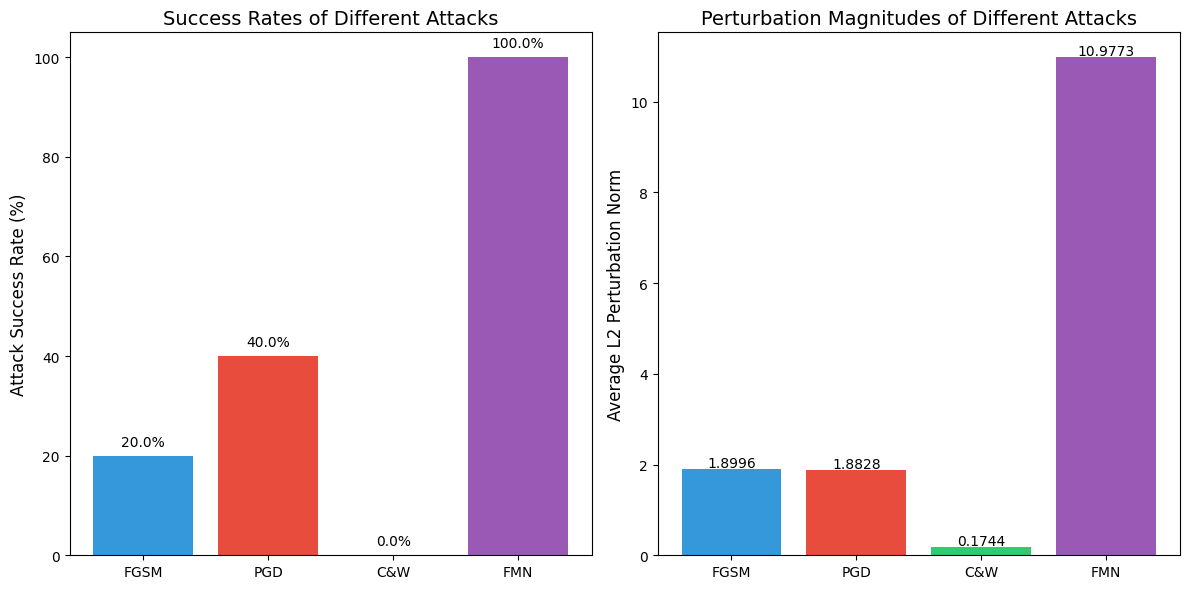

In [24]:
# Compare attack success rates with a bar chart
plt.figure(figsize=(12, 6))

# Success rates
plt.subplot(1, 2, 1)
attacks = ['FGSM', 'PGD', 'C&W', 'FMN']
success_rates = [fgsm_success_rate, pgd_success_rate, cw_success_rate, fmn_success_rate]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

plt.bar(attacks, success_rates, color=colors)
plt.ylabel('Attack Success Rate (%)', fontsize=12)
plt.title('Success Rates of Different Attacks', fontsize=14)
plt.ylim([0, 105])

# Add data labels
for i, rate in enumerate(success_rates):
    plt.text(i, rate + 2, f"{rate:.1f}%", ha='center')

# Perturbation norms
plt.subplot(1, 2, 2)
norms = [avg_fgsm_l2, avg_pgd_l2, avg_cw_l2, avg_fmn_l2]

plt.bar(attacks, norms, color=colors)
plt.ylabel('Average L2 Perturbation Norm', fontsize=12)
plt.title('Perturbation Magnitudes of Different Attacks', fontsize=14)

# Add data labels
for i, norm in enumerate(norms):
    plt.text(i, norm + 0.05, f"{norm:.4f}", ha='center')

plt.tight_layout()
plt.show()

## 10. Visual Comparison of Attacks

Let's visually compare the adversarial examples produced by each attack method.

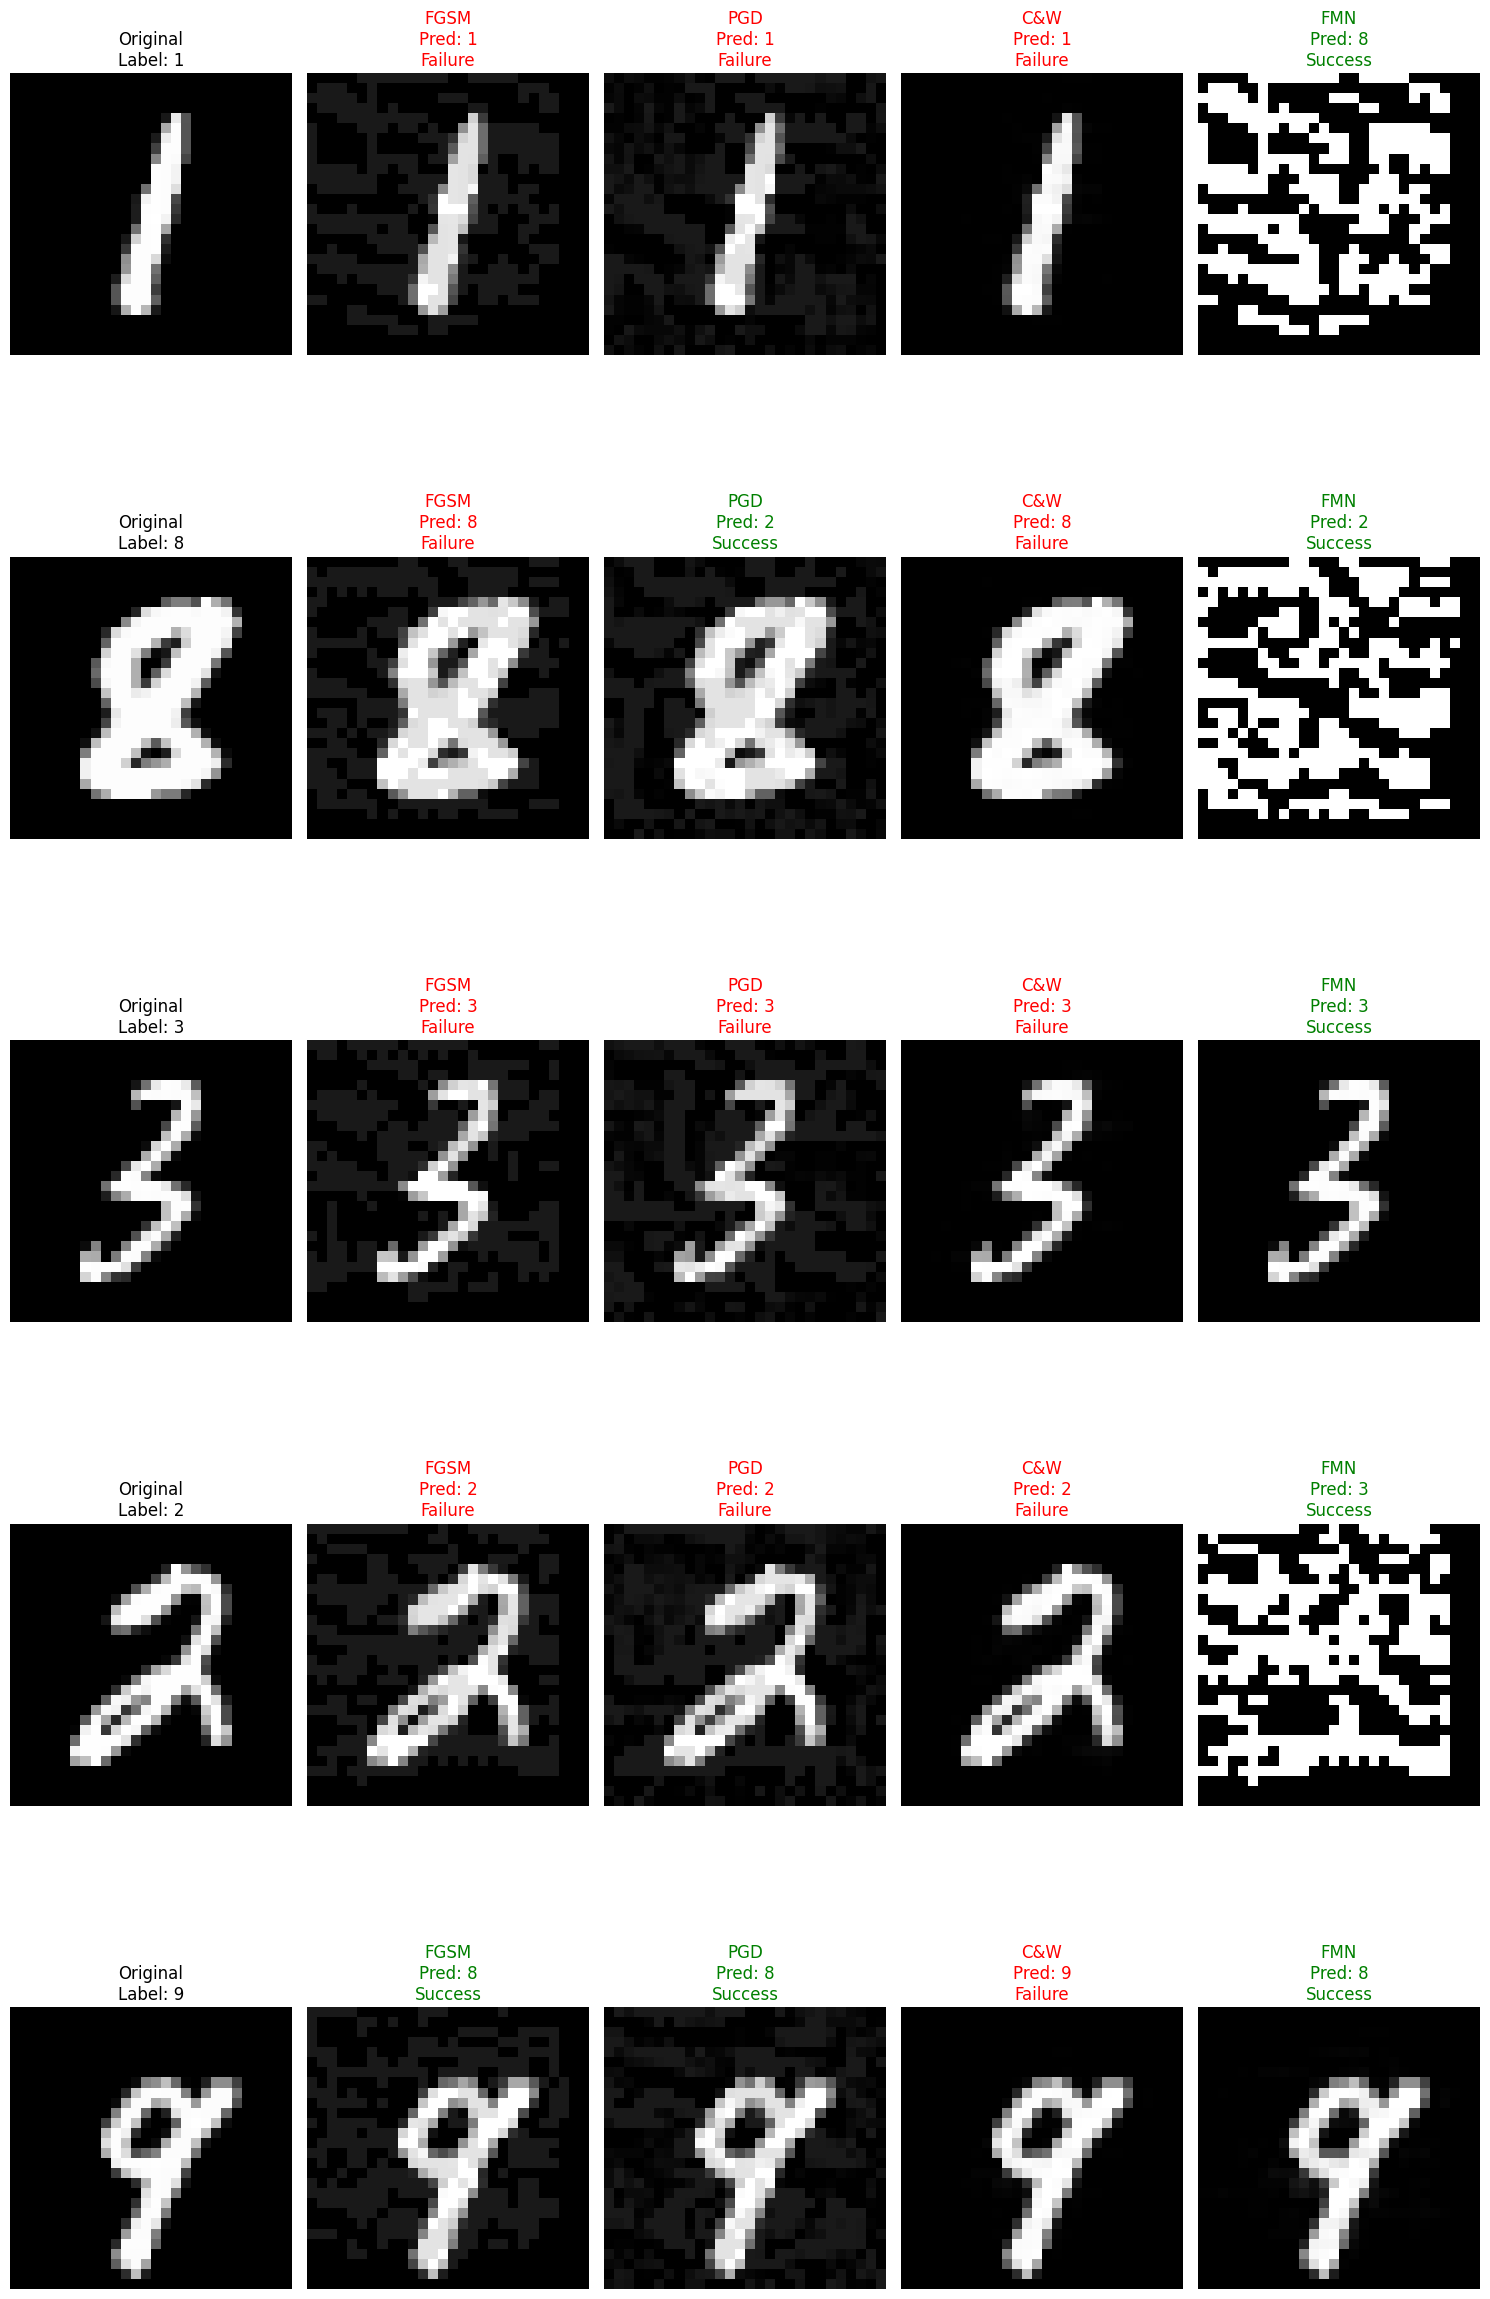

In [27]:
# Visual comparison of the adversarial examples
plt.figure(figsize=(15, 5 * comparison_samples))

for i in range(comparison_samples):
    image = original_images[i]
    true_label = true_labels[i]
    
    # Original image
    plt.subplot(comparison_samples, 5, 5*i + 1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f"Original\nLabel: {true_label}")
    plt.axis('off')
    
    # FGSM adversarial image
    plt.subplot(comparison_samples, 5, 5*i + 2)
    plt.imshow(fgsm_adv_images[i].reshape(28, 28), cmap='gray')
    fgsm_color = 'green' if fgsm_success[i] else 'red'
    fgsm_result_text = 'Success' if fgsm_success[i] else 'Failure'
    plt.title(f"FGSM\nPred: {fgsm_preds[i]}\n{fgsm_result_text}", color=fgsm_color)
    plt.axis('off')
    
    # PGD adversarial image
    plt.subplot(comparison_samples, 5, 5*i + 3)
    plt.imshow(pgd_adv_images[i].reshape(28, 28), cmap='gray')
    pgd_color = 'green' if pgd_success[i] else 'red'
    pgd_result_text = 'Success' if pgd_success[i] else 'Failure'
    plt.title(f"PGD\nPred: {pgd_preds[i]}\n{pgd_result_text}", color=pgd_color)
    plt.axis('off')
    
    # C&W adversarial image
    plt.subplot(comparison_samples, 5, 5*i + 4)
    plt.imshow(cw_adv_images[i].reshape(28, 28), cmap='gray')
    cw_color = 'green' if cw_success[i] else 'red'
    cw_result_text = 'Success' if cw_success[i] else 'Failure'
    plt.title(f"C&W\nPred: {cw_preds[i]}\n{cw_result_text}", color=cw_color)
    plt.axis('off')
    
    # FMN adversarial image
    plt.subplot(comparison_samples, 5, 5*i + 5)
    plt.imshow(adversarial_images[i].reshape(28, 28), cmap='gray')
    fmn_success_flag = successful_attacks[i]
    fmn_color = 'green' if fmn_success_flag else 'red'
    fmn_result_text = 'Success' if fmn_success_flag else 'Failure'
    plt.title(f"FMN\nPred: {adversarial_preds[i]}\n{fmn_result_text}", color=fmn_color)
    plt.axis('off')

plt.tight_layout()
plt.show()